# abstract 파일 불러오기

In [9]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/baekjiyeon/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [129]:
# 파일 불러오기
df = pd.read_pickle("remove_none_in_abs.p")
df.shape

(12218, 6)

In [130]:
df.head()

,idPrefix,id,pubDate,keywords,title,abstract
0,bd,13rRUwvT9j1,2015-01-01,"[Data Integration, Big Data, Data Mining, Feat...",Methodologies for Cross-Domain Data Fusion: An...,Traditional data mining usually deals with dat...
1,bd,13rRUxBJhxj,2015-01-01,"[Semantics, Internet, Electronic Publishing, S...",Embracing Information Explosion without Chokin...,The explosive popularity of microblogging serv...
2,bd,13rRUxAStUe,2015-07-01,"[Data Models, Computational Modeling, Big Data...",Petuum: A New Platform for Distributed Machine...,What is a systematic way to efficiently apply ...
3,bd,13rRUxASu2L,2015-07-01,"[Distributed Databases, Base Stations, Data Pr...",SMC: A Practical Schema for Privacy-Preserved ...,Data collection is required to be safe and eff...
4,bd,13rRUwbJCYJ,1900-01-01,"[Binary Codes, Error Correction Codes, Error C...",Code Consistent Hashing Based on Information-T...,Learning based hashing techniques have attract...


## 초록 전처리

In [131]:
# 초록 전처리
def abstract_to_words( raw_abstract ):
    # 1. HTML 제거
    abstract_text = bs(raw_abstract, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', abstract_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    wordnet_lemmatizer = WordNetLemmatizer()
    result_words = [wordnet_lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(result_words) )

In [132]:
# 멀티 프로세싱 코드
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [133]:
%time clean_train_abstract = apply_by_multiprocessing(\
    df['abstract'], abstract_to_words, workers=32)

CPU times: user 239 ms, sys: 309 ms, total: 548 ms
Wall time: 25.3 s


In [134]:
# 전처리된 초록
clean_train_abstract[:10]

0    traditional data mining usually deal data sing...
1    explosive popularity microblogging service pro...
2    systematic way efficiently apply wide spectrum...
3    data collection required safe efficient consid...
4    learning based hashing technique attracted bro...
5    image retrieval play increasingly important ro...
6    paper study leveraging weakly labeled image un...
7    indexing microblogs realtime search challengin...
8    distributed rdf data management system become ...
9    paper investigate establish relationship seman...
Name: abstract, dtype: object

In [135]:
df['num_words'] = clean_train_abstract.apply(lambda x: len(str(x).split()))
df['num_uniq_words'] = clean_train_abstract.apply(lambda x: len(set(str(x).split())))

In [136]:
df[['num_words','num_uniq_words']].head()

,num_words,num_uniq_words
0,163,98
1,120,85
2,140,109
3,112,73
4,101,77


In [137]:
# 첫 번째 초록에 
x = clean_train_abstract[0]
x = str(x).split()
print(len(x))
x[:10]

163


['traditional',
 'data',
 'mining',
 'usually',
 'deal',
 'data',
 'single',
 'domain',
 'big',
 'data']

In [164]:
absdata = df[['id','pubDate','keywords','title','abstract','clean_train_abstract']]

In [166]:
absdata.to_pickle('absdata.p')

## 초록 별 단어 특징

초록별 단어 평균 값 : 101.00147323620887
초록별 단어 중간 값 105.0
초록별 고유 단어 평균 값 : 71.1853003764937
초록별 고유 단어 중간 값 74.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'초록별 고유한 단어 수 분포')

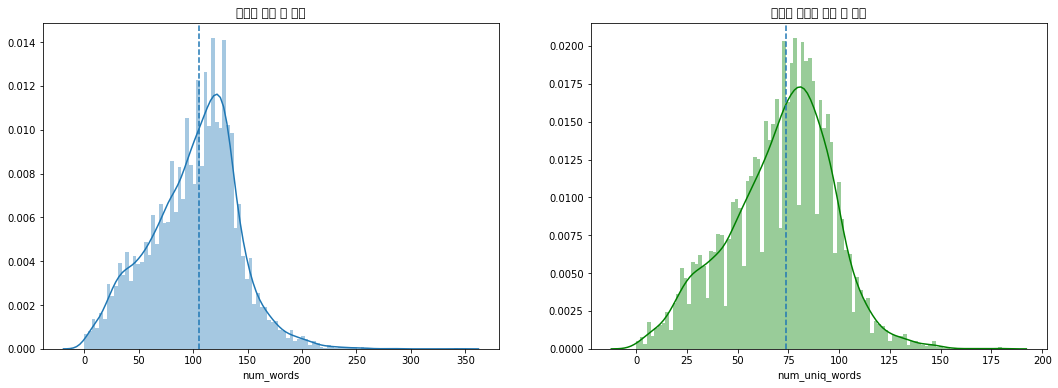

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('초록별 단어 평균 값 :', df['num_words'].mean())
print('초록별 단어 중간 값', df['num_words'].median())
sns.distplot(df['num_words'], bins=100, ax=axes[0])
axes[0].axvline(df['num_words'].median(), linestyle='dashed')
axes[0].set_title('초록별 단어 수 분포')

print('초록별 고유 단어 평균 값 :', df['num_uniq_words'].mean())
print('초록별 고유 단어 중간 값', df['num_uniq_words'].median())
sns.distplot(df['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(df['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('초록별 고유한 단어 수 분포')

In [140]:
df['clean_train_abstract'] = clean_train_abstract

In [141]:
df.head()

,idPrefix,id,pubDate,keywords,title,abstract,num_words,num_uniq_words,clean_train_abstract
0,bd,13rRUwvT9j1,2015-01-01,"[Data Integration, Big Data, Data Mining, Feat...",Methodologies for Cross-Domain Data Fusion: An...,Traditional data mining usually deals with dat...,163,98,traditional data mining usually deal data sing...
1,bd,13rRUxBJhxj,2015-01-01,"[Semantics, Internet, Electronic Publishing, S...",Embracing Information Explosion without Chokin...,The explosive popularity of microblogging serv...,120,85,explosive popularity microblogging service pro...
2,bd,13rRUxAStUe,2015-07-01,"[Data Models, Computational Modeling, Big Data...",Petuum: A New Platform for Distributed Machine...,What is a systematic way to efficiently apply ...,140,109,systematic way efficiently apply wide spectrum...
3,bd,13rRUxASu2L,2015-07-01,"[Distributed Databases, Base Stations, Data Pr...",SMC: A Practical Schema for Privacy-Preserved ...,Data collection is required to be safe and eff...,112,73,data collection required safe efficient consid...
4,bd,13rRUwbJCYJ,1900-01-01,"[Binary Codes, Error Correction Codes, Error C...",Code Consistent Hashing Based on Information-T...,Learning based hashing techniques have attract...,101,77,learning based hashing technique attracted bro...


# word2vec 모델로 만들기

In [57]:
# 데이터 불러오기
word2vec_test = pd.DataFrame()

In [58]:
word2vec_test['abstract'] = df['abstract']

In [59]:
word2vec_test.head()

,abstract
0,Traditional data mining usually deals with dat...
1,The explosive popularity of microblogging serv...
2,What is a systematic way to efficiently apply ...
3,Data collection is required to be safe and eff...
4,Learning based hashing techniques have attract...


In [66]:
word2vec_test.abstract[0]

'Traditional data mining usually deals with data from a single domain. In the big data era, we face a diversity of datasets from different sources in different domains. These datasets consist of multiple modalities, each of which has a different representation, distribution, scale, and density. How to unlock the power of knowledge from multiple disparate (but potentially connected) datasets is paramount in big data research, essentially distinguishing big data from traditional data mining tasks. This calls for advanced techniques that can fuse knowledge from various datasets organically in a machine learning and data mining task. This paper summarizes the data fusion methodologies, classifying them into three categories: stage-based, feature level-based, and semantic meaning-based data fusion methods. The last category of data fusion methods is further divided into four groups: multi-view learning-based, similarity-based, probabilistic dependency-based, and transfer learning-based meth

In [68]:
# 초록 전체를 문장으로 나누기
word2vec_test['sentences'] = word2vec_test.abstract.apply(lambda x : x.split('.'))

In [72]:
word2vec_test.sentences[0][:5]

['Traditional data mining usually deals with data from a single domain',
 ' In the big data era, we face a diversity of datasets from different sources in different domains',
 ' These datasets consist of multiple modalities, each of which has a different representation, distribution, scale, and density',
 ' How to unlock the power of knowledge from multiple disparate (but potentially connected) datasets is paramount in big data research, essentially distinguishing big data from traditional data mining tasks',
 ' This calls for advanced techniques that can fuse knowledge from various datasets organically in a machine learning and data mining task']

In [75]:
# 초록들의 문장들을 단어들로 분리
def sentences_to_words( raw_sentences ):
    result = []
    for sentence in raw_sentences:
        # 1. HTML 제거
        sentences_text = bs(sentence, 'html.parser').get_text()
        # 2. 영문자가 아닌 문자는 공백으로 변환
        letters_only = re.sub('[^a-zA-Z]', ' ', sentences_text)
        # 3. 소문자 변환
        words = letters_only.lower().split()
        # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
        # stopwords 를 세트로 변환한다.
        stops = set(stopwords.words('english'))
        # 5. Stopwords 불용어 제거
        meaningful_words = [w for w in words if not w in stops]
        # 6. 어간추출
        wordnet_lemmatizer = WordNetLemmatizer()
        result_words = [wordnet_lemmatizer.lemmatize(w) for w in meaningful_words]
        result.append(result_words)
        
    return(result)

In [80]:
%time clean_sentence2words = apply_by_multiprocessing(\
    word2vec_test['sentences'], sentences_to_words, workers=64)

CPU times: user 2.31 s, sys: 2.65 s, total: 4.96 s
Wall time: 3min 13s


In [103]:
clean_sentence2words[0][0][:]

['traditional',
 'data',
 'mining',
 'usually',
 'deal',
 'data',
 'single',
 'domain']

In [94]:
# 멀티 프로세싱을 위해 2차원으로 축소
sum_sentences = clean_sentence2words.sum()

In [102]:
sum_sentences[0]

['traditional',
 'data',
 'mining',
 'usually',
 'deal',
 'data',
 'single',
 'domain']

In [86]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [104]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sum_sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2018-11-29 00:44:09,840 : INFO : collecting all words and their counts
2018-11-29 00:44:09,842 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-29 00:44:09,868 : INFO : PROGRESS: at sentence #10000, processed 122610 words, keeping 8823 word types
2018-11-29 00:44:09,898 : INFO : PROGRESS: at sentence #20000, processed 245189 words, keeping 12584 word types
2018-11-29 00:44:09,931 : INFO : PROGRESS: at sentence #30000, processed 367825 words, keeping 14521 word types
2018-11-29 00:44:09,961 : INFO : PROGRESS: at sentence #40000, processed 488097 words, keeping 16805 word types
2018-11-29 00:44:09,994 : INFO : PROGRESS: at sentence #50000, processed 604514 words, keeping 19764 word types
2018-11-29 00:44:10,028 : INFO : PROGRESS: at sentence #60000, processed 713513 words, keeping 21982 word types
2018-11-29 00:44:10,055 : INFO : PROGRESS: at sentence #70000, processed 829423 words, keeping 23936 word types
2018-11-29 00:44:10,084 : INFO : PROGRESS: at s

In [105]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

2018-11-29 00:45:06,462 : INFO : precomputing L2-norms of word weight vectors


In [106]:
# 만든 모델 저장하기
model_name = '300features_40minwords_10text'
model.save(model_name)

2018-11-29 00:45:17,399 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2018-11-29 00:45:17,401 : INFO : not storing attribute vectors_norm
2018-11-29 00:45:17,403 : INFO : not storing attribute cum_table
2018-11-29 00:45:17,551 : INFO : saved 300features_40minwords_10text


In [107]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('data big vision analysis'.split())

'vision'

In [111]:
# 가장 유사한 단어를 추출
model.wv.most_similar("ram")

[('dram', 0.9356028437614441),
 ('stt', 0.9308456778526306),
 ('sram', 0.9275686740875244),
 ('write', 0.8973929286003113),
 ('cache', 0.8718557357788086),
 ('flash', 0.8425916433334351),
 ('bank', 0.8311843872070312),
 ('bus', 0.8289868831634521),
 ('memory', 0.8127608299255371),
 ('associative', 0.8083827495574951)]

## Word2Vec으로 벡터화 한 단어를 t-SNE 를 통해 시각화

In [119]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:,:])
# X_tsne = tsne.fit_transform(X)

2018-11-29 00:50:24,928 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2018-11-29 00:50:24,992 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-11-29 00:50:24,993 : INFO : setting ignored attribute vectors_norm to None
2018-11-29 00:50:24,994 : INFO : loading vocabulary recursively from 300features_40minwords_10text.vocabulary.* with mmap=None
2018-11-29 00:50:24,995 : INFO : loading trainables recursively from 300features_40minwords_10text.trainables.* with mmap=None
2018-11-29 00:50:24,995 : INFO : setting ignored attribute cum_table to None
2018-11-29 00:50:24,995 : INFO : loaded 300features_40minwords_10text
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


3588
[-0.02701321  0.12012333 -0.1790664  -0.06605331  0.03607208 -0.02281567
  0.04191756  0.01086267 -0.05739459 -0.01203837]


In [125]:
w2v_df = pd.DataFrame(X_tsne, index=vocab[:], columns=['x', 'y'])

In [126]:
w2v_df.shape

(3588, 2)

In [146]:
w2v_df.head(10)

,x,y
traditional,-17.779083,-57.400478
data,-0.531502,-22.240061
mining,19.149387,-23.269342
usually,6.436648,-50.713032
deal,34.961720,-42.882214
single,-39.460503,27.462442
domain,30.823874,24.171972
big,8.426910,-45.354660
era,12.230211,-41.254280
face,38.887306,6.144530


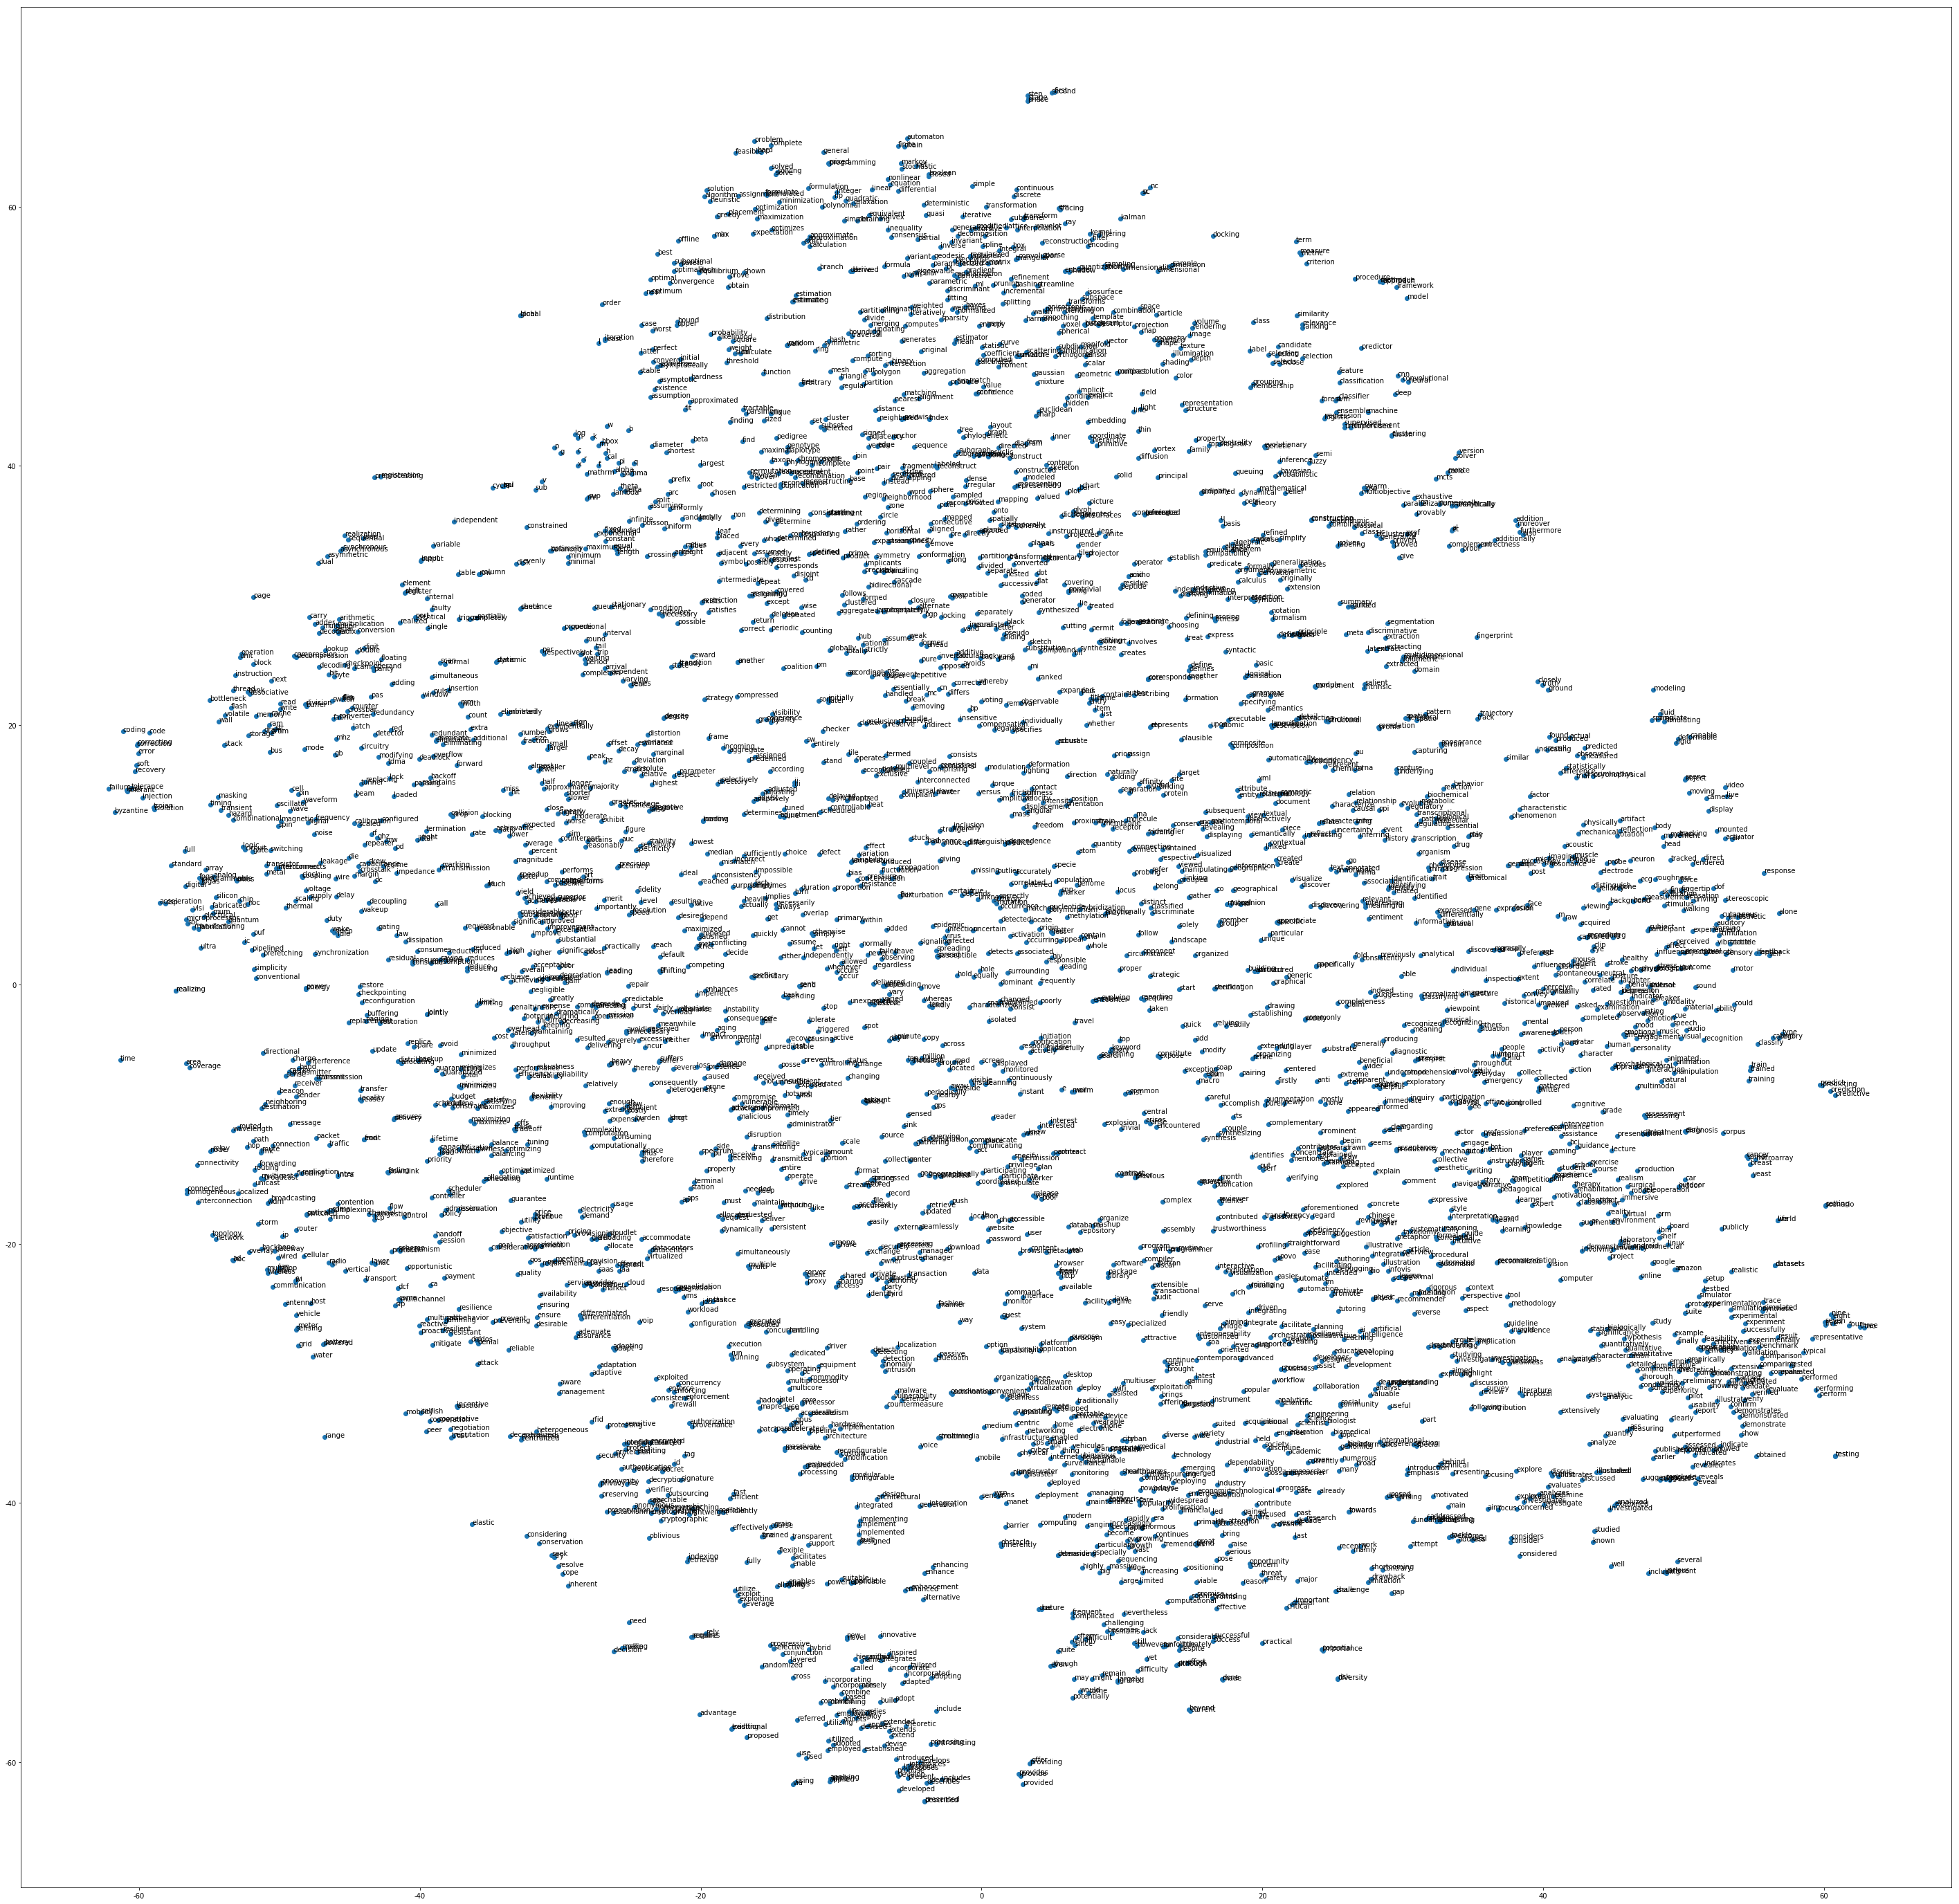

In [148]:
fig = plt.figure()
fig.set_size_inches(50, 50)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_df['x'], w2v_df['y'])

for word, pos in w2v_df.iterrows():
    ax.annotate(word, pos, fontsize=10)
plt.show()

In [150]:
fig_name = '300features_40minwords_10text'
fig.savefig(fig_name)